In [1]:
%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import shutil

# manejo y procesamiento de datos
from netCDF4 import Dataset
import pandas as pd
import numpy as np

# vizualisación
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from clawpack.visclaw import colormaps, plottools


In [3]:
Folder = '/home/jorge/PTHA/Dataset/mw_91-93/' #OK
path = os.getcwd()
Folder_save = path+'/ALL-ESC/'
if not os.path.exists(Folder_save):
    os.makedirs(Folder_save)


## Agrupar escenarios 

In [4]:
%%time
folders = os.listdir(Folder)
folders.sort()
for fol in folders: #recorre carpetas distintas magnitud
    print('Mw',fol)
    magnitud = os.listdir(Folder+'/'+fol)
    magnitud.sort()
    for m in magnitud :#recorre distintos escenarios dentro de cada magnitud
        escenario = os.listdir(Folder+'/'+fol+'/'+m)
        for esc in escenario:
            if esc.endswith("level04valp.nc") : # acepta archivo valido 'level04.nc'
                file = Folder+'/'+fol+'/'+m+'/'+esc
                name = fol+'-'+m+'-'+esc
                shutil.copy(file, Folder_save+'/'+name)

Mw mw_91
Mw mw_92
Mw mw_93
CPU times: user 208 ms, sys: 1.27 s, total: 1.47 s
Wall time: 2.85 s


## Generar Matriz con todos los escenarios (vector columna).

In [5]:
%%time
Escenarios = os.listdir(Folder_save)
Escenarios.sort()
Matrix = []
Mw = []
Escc = []
for esc in Escenarios:
    file = Folder_save+'/'+esc
    f=Dataset(file)
    Matrix.append((f.variables['max_height'][:]).data.flatten())
Lon = f.variables['lon'][:]
Lat = f.variables['lat'][:]
Bathy = f.variables['original_bathy'][:]
Df = pd.DataFrame(Matrix)
Df = Df.replace({-9999.0: 0.0})

CPU times: user 1min 39s, sys: 3.18 s, total: 1min 42s
Wall time: 1min 43s


## Parametros estadisticos

In [26]:
%%time
Tiempo = 10000 # [años]
h0 = 10 # umbral de referencia en metros
dT = 500 # ventana de tiempo



CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 33.4 µs


In [27]:
TasaExc= (Df>h0).sum()/Tiempo
ProbExc = 1-np.exp(-TasaExc*dT)

In [28]:

zmin = 0.
zmax = 1.

cmap_land = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})

cmap_water = colormaps.make_colormap({ 0.0:[0,0,1], 1.:[.8,.8,1]})

cmap_topo, norm_topo = colormaps.add_colormaps((cmap_land, cmap_water),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)

# Color map for hmax:

clines = [0,.05,0.1] + list(linspace(0.2,1.0,8))
nlines = len(clines)
n1 = int(floor((nlines-1)/2.))
n2 = nlines - 1 - n1
Green = hstack([linspace(1,1,n1),linspace(1,0,n2)])
Red = hstack([linspace(0,0.8,n1), ones(n2)])
Blue = hstack([linspace(1,0.2,n1), zeros(n2)])
hmax_colors = list(zip(Red,Green,Blue))

Text(0.5, 1.0, 'Probability of Exceedance I0 =10, dT = 500')

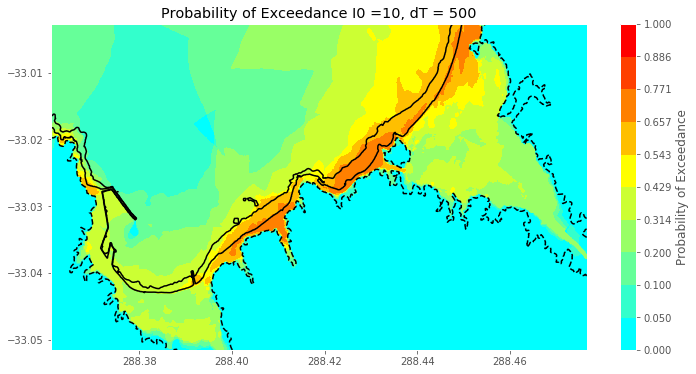

In [29]:

figure(figsize=(12,6))
contour(Lon,Lat,Bathy,[-30,0,10], colors='k')
ProbExc = np.array(ProbExc).reshape(Lat.shape[0],Lon.shape[0])
#ProbExc = where(ProbExc==0, nan, ProbExc)
#Prob_onshore = where(Bathy<0, ProbExc, nan)
cf = contourf(Lon,Lat,ProbExc,clines,colors=hmax_colors)
cbar = colorbar(label='Probability of Exceedance')
cbar.set_ticks(clines)
#plt.scatter(288.4423421223963,-33.018977355957006)
title('Probability of Exceedance %s' % 'I0 ='+str(h0)+ ', dT = ' + str(dT))